In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import peakutils



## Generate sine wave data points

In [151]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.4
points_per_cycle = int((2*np.pi) / sample_rate)*10


x_range = np.arange(start=-np.pi/2, stop=60*2*np.pi, step=sample_rate)
print(max(x_range))
mult_start = 0.9
mult_end = 0.7
mult_range = mult_end - mult_start

period_multiplier = np.arange(mult_start, mult_end, mult_range/len(x_range))
#b = np.arange(0.5, 1, 1/len(a))
data = [np.sin(i*j) for i,j in zip(x_range, period_multiplier)]
#Shift the dataset up so we can use -1 as our NaN value
shiftData = [data[i] + -min(data) for i in range(len(data))] 
data = shiftData

print("Total data points: " + str(len(data)))


376.82920367320503
Total data points: 947


## Grab the start and end points of each cycle

In [152]:
#Negate force values to find a trough using the same peak function
negated_vals = [-i for i in data]

#Grab the peak and trough times (these are also indices)
peak_times = peakutils.indexes(data, thres=0.5, min_dist=0.1)
trough_times = peakutils.indexes(negated_vals, thres=0.5, min_dist=0.1)

#Find the time's corresponding y value
peak_vals = [data[i] for i in peak_times]
trough_vals = [data[i] for i in trough_times]

## Generate a dataset using padding

In [153]:
#Collect all the period values from the dataset
periods = []
for i in range(len(trough_times) - 1):
    period = trough_times[i+1] - trough_times[i]
    periods.append(period)

max_period = 130#periods[-1]

In [154]:


#Always capture three full waves. A single wave is represented by peak-to-peak. So each example needs a 3 peaks pairs.

#To capture cycles without starting and ending at only peaks each time, 
# use percentages of points realtive to the distance(num points) between the two peaks.
# so if an example starts n points before the first peak, then use n/(n_cyle_points) as the num points to use ahead



"""
Algorithm

3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed
and adding P more points to the end. 


1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time


2. In Loop
    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".
    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    


3.Last stage should just pad each example so they're all of the same dimension
    
    
    Use percentage offset of points from a peak to approximate where to end. 
        (for example that doesnt perfectly capture all peaks)




***Maybe idea is that it should always have at least enough peaks to form n-1 waves and 
extrapolate the rest based on previously seen info

Maybe should always see n peaks, and expand if not

"""





'\nAlgorithm\n\n3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed\nand adding P more points to the end. \n\n\n1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time\n\n\n2. In Loop\n    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".\n    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    \n\n\n3.Last stage should just pad each example so they\'re all of the same dimension\n    \n    \n    Use percentage offset of points from a peak to approximate where to end. \n        (for example that doesnt perfectly capture all peaks)\n\n\n\n\n***Maybe idea is that it should always have at least enough peaks to form n-1 waves and \nextrapolate the rest based on previously seen info\n\nMaybe should always see n peaks, and expand if not\n\n'

----------------------
[0.012311598882902342, 0.13085565006125277, 0.3608510343434014, 0.672664984676258, 1.0262555573684125, 1.376328264806566, 1.678142692910974, 1.893224214617118, 1.9942524951871876, 1.968507807711478, 1.819443583363091, 1.5661946469330759, 1.2410941667563697, 0.8855248201593493, 0.5446390874184819, 0.261623726504155, 0.07223714156741123, 0.0003094308765211329, 0.05476903669310995, 0.22856370508779178, 0.49960221549267314, 0.8335878305198752, 1.1883769438259235, 1.5193067099377588, 1.7848169969083099, 1.9516591242849388, 1.9990399837526118, 1.9211875450428606, 1.7280245703157449, 1.4438759629113411, 1.1043814309247493, 0.7520082335295635, 0.43073104393690753, 0.18054633474615067, 0.03250523907071956, 0.004880171613401929, 0.1009358225082464, 0.30857303635835087, 0.60188009402603, 0.9443892868872187, 1.2936267395584977, 1.6063859601990074, 1.8440696253909983, 1.9774396859504693, 1.990192904962666, 1.8809272646718045, 1.6632654686493704, 1.3641298968874502, 1.02039058

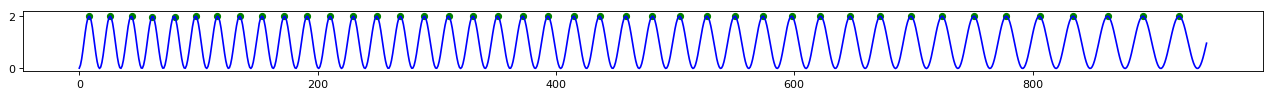

In [155]:
def generate_dataset_const(data, peak_indices, x_cycles=3, y_cycles=1):
    #Just use a window size that corresponds to the average of the the period of the wave that the first point
    # lies in and the period of the wave that the last point lies in. 
    # The predict window size should be period that last feed-in point lies in + (plus)
    # the growth we saw between the last two waves
    """For now: Decide num points to use by finding num points in first and last wave and slide size over this domain.
    Then each point along the series should correspond to a "period" value. 
    Each time we slide one point over, we then look at how much we should expand on the right side (later in series).
    This amount of expansion is determined by the average period value of all the points in the past window.
    """
    
    
    #Set some variables to use
    smallest_period = peak_indices[1] - peak_indices[0]
    largest_period = peak_indices[-1] - peak_indices[-2] 
    period_range = largest_period - smallest_period
    holder_size = int(largest_period * 1.1)
    
    #Assign an approximate period-value to each point over the distribution from smallest to largest
    approx_periods = [int(smallest_period + i) for i in np.linspace(0, period_range, len(data))]
    
    
    n_prev = smallest_period*3
    n_forecast = smallest_period
    print("----------------------")
    print(data[0:n_prev])
    fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')

    #Line plot along the true data
    plt.plot([x for x in range(len(data))], data, color="blue")

    #Plot the training points in green
    plt.scatter(peak_indices, peak_vals, color="green", s=30)

    print("----------------------")

    #Loop over the data and convert into samples
    for i in range(len(data)):
        
        #Init our examples input and label
        x = [-1]* (holder_size*x_cycles)
        y = [-1]* (holder_size*y_cycles)
        
        
        x[:n_prev] = data[i:i+n_prev]
        y[:n_forecast] = data[i+n_prev:i+n_prev+n_forecast]
        
        
        print(x)
        print(y)
        break
        
        
        #Calculate the new period to use
        new_period_size = int(np.average(approx_periods[i:i+n_prev]))
        n_prev = new_period_size*3
        n_forecast = new_period_size
        
        
        

    
    #     n_prev = smallest_period*3
    #     n_forecast = smallest_period
    #     example = [-1]*n_prev
    

    


    
    
generate_dataset_const(shiftData, peak_times)
    
    

In [144]:
l = [-1]*10
print(l)

m = [1,2,3,4]

l[:len(m)] = m
print(l)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, 2, 3, 4, -1, -1, -1, -1, -1, -1]


## Train a network to predict the next period

In [133]:
periods = []

for i in range(len(trough_indices) - 1):
    period = trough_indices[i+1] - trough_indices[i]
    
    periods.append(period)

print(periods[-1])


123


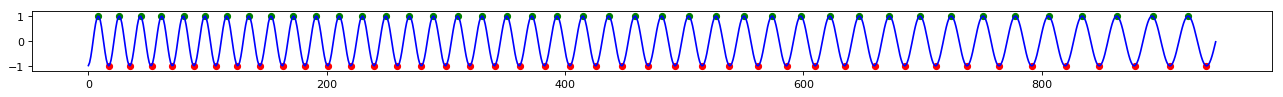

In [134]:
#Plot
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')

#Line plot along the true data
plt.plot([x for x in range(len(data))], data, color="blue")

#Plot the training points in green
plt.scatter(peak_times, peak_vals, color="green", s=30)
plt.scatter(trough_times, trough_vals, color="red", s=30)

# print(peak_val_indices)



#Make a dataframe here
#Generalize this function so that it can capture the local min and maxima and use this automatically as a feature





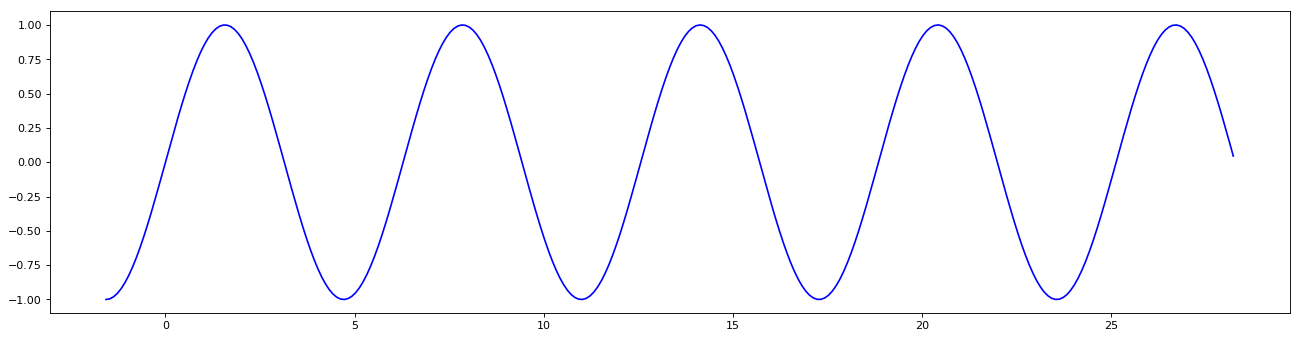

In [37]:
xs = np.arange(-np.pi/2, 4.5*2*np.pi, 0.1)
a = [np.sin(x) for x in xs]


fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(xs, a, color="blue")
plt.scatter()


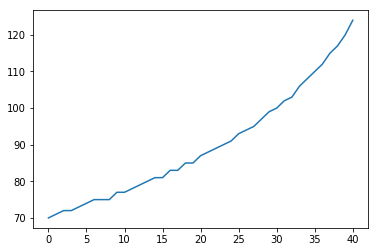

In [67]:
periods = []

for i in range(len(trough_indices) - 1):
    period = trough_indices[i+1] - trough_indices[i]
    
    periods.append(period)

plt.plot(periods)
plt.show()

# Learn period growth

In [104]:
#Organize into data for training

Xs = []

Ys = []

x_size = 3
y_size = 1
example_size = x_size + y_size

#periods = [i for i in range(100)]

for i in range(len(periods) - example_size + 1):
    
    Xs.append([periods[x+i] for x in range(x_size)])
    Ys.append(periods[i+x_size])

print(Xs)
print(Ys)
print("-------------")


print(periods)




[[70, 71, 72], [71, 72, 72], [72, 72, 73], [72, 73, 74], [73, 74, 75], [74, 75, 75], [75, 75, 75], [75, 75, 77], [75, 77, 77], [77, 77, 78], [77, 78, 79], [78, 79, 80], [79, 80, 81], [80, 81, 81], [81, 81, 83], [81, 83, 83], [83, 83, 85], [83, 85, 85], [85, 85, 87], [85, 87, 88], [87, 88, 89], [88, 89, 90], [89, 90, 91], [90, 91, 93], [91, 93, 94], [93, 94, 95], [94, 95, 97], [95, 97, 99], [97, 99, 100], [99, 100, 102], [100, 102, 103], [102, 103, 106], [103, 106, 108], [106, 108, 110], [108, 110, 112], [110, 112, 115], [112, 115, 117], [115, 117, 120]]
[72, 73, 74, 75, 75, 75, 77, 77, 78, 79, 80, 81, 81, 83, 83, 85, 85, 87, 88, 89, 90, 91, 93, 94, 95, 97, 99, 100, 102, 103, 106, 108, 110, 112, 115, 117, 120, 124]
-------------
[70, 71, 72, 72, 73, 74, 75, 75, 75, 77, 77, 78, 79, 80, 81, 81, 83, 83, 85, 85, 87, 88, 89, 90, 91, 93, 94, 95, 97, 99, 100, 102, 103, 106, 108, 110, 112, 115, 117, 120, 124]


In [105]:
from keras.models import Sequential
from keras.layers import Dense, Activation

nb_epoch = 100
n_batch = 30

# Build the neural net
model = Sequential()
model.add(Dense(x_size, input_dim=x_size))
model.add(Activation('relu'))
model.add(Dense(y_size))

#Compile the network
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])


history = model.fit(np.array(Xs), np.array(Ys), epochs=nb_epoch, batch_size=1, verbose=1, shuffle=False)


Epoch 1/100
38/38 [==============================] - 1s 19ms/step - loss: 4347.8982 - acc: 0.0000e+00
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 2338.2696 - acc: 0.0000e+00
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 1201.0520 - acc: 0.0000e+00
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 563.4680 - acc: 0.0000e+00
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 233.4648 - acc: 0.0000e+00
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 83.3347 - acc: 0.0000e+00
Epoch 7/100
38/38 [==============================] - 0s 2ms/step - loss: 25.3950 - acc: 0.0000e+00
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 6.8245 - acc: 0.0000e+00
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 1.9756 - acc: 0.2368
Epoch 10/100
38/38 [==============================] - 0s 2ms/step - loss: 0.9906 - acc: 0.5000
Epoch 11/10

dict_keys(['loss', 'acc'])


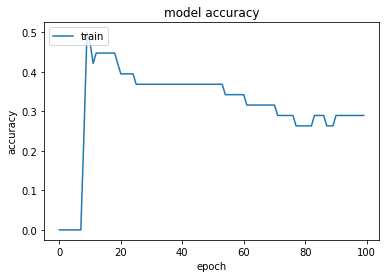

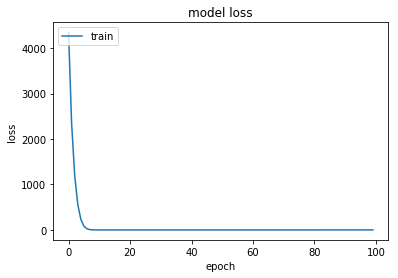

In [106]:
#list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(np.array([i for i in range(x_size)]).shape)

prediction = model.predict(np.array(periods))
#fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
#plt.scatter(prediction, [i for i in range(200)], color="green", s=30)
print(prediction)

## Data Formatting
* `series_to_examples`: Function to convert a 1D series into example data consisting of `X` and `Y` columns
* `prepare_data`: Function to prepare and split data into `train`/`test` sets

* NOTE: We can also add scaling in these functions, to squash values closer together


In [58]:
# Convert 1D series into example data of X and Y columns
def series_to_examples(series, n_prev=1, n_forecast=1, dropnan=True):
    """
    Transform time series data into supervised learning dataset.
    Arguments: 
        series: Sequence of observations as a list
        n_prev: Number of lag observations as input (X)
        n_forecast: Number of observations to predict (Y)
        dropnan: Boolean to drop rows with NaN values resulting from shift
    Returns:
        Pandas Dataframe
        
    Note: by this logic we should have N = (n_prev + n_forecast) columns
     and (series_len - N + 1) rows
    """
    
    #Robust check for whether or not series is univariate or multi-variate
    #If not a simple list (univariate), then the columns of shape will tell you how many variables
    num_dims = 1 if type(series) is list else series.shape[1]
    
    #convert the series to a dataframe format for shift
    df = pd.DataFrame(series)
    
    #Cols is a list of lists where each inner list is a whole column
    cols, names = list(), list()
    
    #Build each column of the input, first column will be fully shifted (i.e oldest example seen) 
    for i in range(n_prev, 0, -1):
        cols.append(df.shift(i))
        #names just a list??
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build each column of the output forecasts (t, t+1, ...)
    for i in range(0, n_forecast):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_dims)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build a final dataframe columns side by side & attach names
    final = pd.concat(cols, axis=1)
    final.columns = names

    
    #Remove all rows with NaN values
    if dropnan:
        final.dropna(inplace=True)
    return final  



#Prepare and split data into train/test sets
def prepare_data(series, n_test, n_prev, n_forecast):#, batch_size):
    
    #Prepare data handles intital split!!!
    
    #NEW: Split before sending into series_to_examples
    train, test = series[:-n_test], series[-n_test:] 
    
    
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_train = series_to_examples(train, n_prev, n_forecast)
    
    #Drop excess examples to allow for varying batch size
    #cutoff = int(len(df_train)/batch_size) * batch_size
    #df_train = df_train[:cutoff]
    
    #Extract and retain structure of values from dataframe
    example_values_train = df_train.values
    
    return example_values_train, test


## Define data structure to be passed to network

In [59]:
#Test size has to be large enough to encompass one full cycle

n_prev = points_per_cycle * 3
n_forecast = points_per_cycle

#The test data has to encompass both n_prev points and n_forecast points
#We feed the first n_prev points of the test into the network to make a prediction and compare this to n_forecast
#(This is just enough to predict one cycle)
n_test = n_prev + n_forecast# int(len(data)*0.2)


train, test = prepare_data(data, n_test, n_prev, n_forecast)#, batch_size)
print("Train is a matrix. Rows=examples; Cols=total points in an example;   train.shape: " + str(train.shape))
print("Test is a vector of size total number of points in an example;       test size: " + str(len(test)))
print(n_prev)
print(n_forecast)


Empty DataFrame
Columns: [var1(t-1860), var1(t-1859), var1(t-1858), var1(t-1857), var1(t-1856), var1(t-1855), var1(t-1854), var1(t-1853), var1(t-1852), var1(t-1851), var1(t-1850), var1(t-1849), var1(t-1848), var1(t-1847), var1(t-1846), var1(t-1845), var1(t-1844), var1(t-1843), var1(t-1842), var1(t-1841), var1(t-1840), var1(t-1839), var1(t-1838), var1(t-1837), var1(t-1836), var1(t-1835), var1(t-1834), var1(t-1833), var1(t-1832), var1(t-1831), var1(t-1830), var1(t-1829), var1(t-1828), var1(t-1827), var1(t-1826), var1(t-1825), var1(t-1824), var1(t-1823), var1(t-1822), var1(t-1821), var1(t-1820), var1(t-1819), var1(t-1818), var1(t-1817), var1(t-1816), var1(t-1815), var1(t-1814), var1(t-1813), var1(t-1812), var1(t-1811), var1(t-1810), var1(t-1809), var1(t-1808), var1(t-1807), var1(t-1806), var1(t-1805), var1(t-1804), var1(t-1803), var1(t-1802), var1(t-1801), var1(t-1800), var1(t-1799), var1(t-1798), var1(t-1797), var1(t-1796), var1(t-1795), var1(t-1794), var1(t-1793), var1(t-1792), var1(t-1

## Visualize total dataset and goal in red

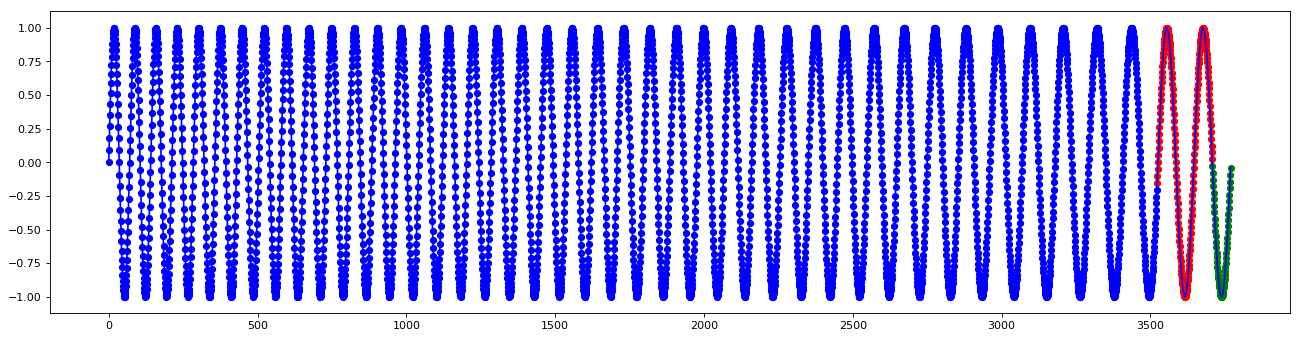

In [116]:
#Set the figure parameters
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Grab the points for each section of the plot
train_points, test_input_points, test_label_points = data[:-n_test], data[-n_test:-n_forecast], data[-n_forecast:]

#Plot the training data and the underlying curve in blue 
plt.plot(data, color="blue")
train_plot_x = [x for x in range(len(train_points))]
plt.scatter(train_plot_x, train_points, color="blue", s=30)

#Plot the test example X in red
test_input_xs = [x +len(train_points) for x in range(len(test_input_points))]
plt.scatter(test_input_xs, test_input_points, color="red", s=30)

#Plot the test target label in green
test_label_xs = [x +(len(train_points)+len(test_input_points)) for x in range(len(test_label_points))]
plt.scatter(test_label_xs, test_label_points, color="green", s=30)



## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [24]:
# fit an LSTM network to training data

def fit_lstm(train, n_prev, n_forecast, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    

    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print("sam")
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=False))
    architecture += "LSTM; "
    #model.add(Dense(300))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #Fit the network to the training data
    for i in range(nb_epoch):
        start = timer()
        print(i)
        
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
        
        end = timer()
        print("Epoch duration: " + str(end - start))
    return model, architecture

In [38]:
print(train.shape)
train = train[:-26]
print(train.shape)

(1076, 248)
(1050, 248)


## Train the Neural Network

In [41]:
n_epochs = 200
n_batch = 50
n_neurons = 30
print("train shape: " + str(train.shape))
#train_cut = train[:-2,:]
train_cut = train
print("train shape: " + str(train_cut.shape))

model, architecture = fit_lstm(train_cut, n_prev, n_forecast, n_batch, n_epochs, n_neurons)


train shape: (1050, 248)
train shape: (1050, 248)
X shape: (1050, 186)
y shape: (1050, 62)
sam
(50, 186, 1)
(1050, 186, 1)
0
Epoch duration: 3.843668423998679
1
Epoch duration: 2.0905228310002713
2
Epoch duration: 2.118313275001128
3
Epoch duration: 2.191217333000168
4
Epoch duration: 2.2841942649993143
5
Epoch duration: 2.2670102090014552
6
Epoch duration: 2.3634533029999147
7
Epoch duration: 2.3770723920006276
8
Epoch duration: 2.3604065159997845
9
Epoch duration: 2.321709331999955
10
Epoch duration: 2.283580458999495
11
Epoch duration: 2.3231336419994477
12
Epoch duration: 2.304557928999202
13
Epoch duration: 2.261453539998911
14
Epoch duration: 2.299736885999664
15
Epoch duration: 2.262070982998921
16
Epoch duration: 2.3073163829994883
17
Epoch duration: 2.136278820998996
18
Epoch duration: 2.275641337999332
19
Epoch duration: 2.4193658309995953
20
Epoch duration: 2.4701243649997195
21
Epoch duration: 2.5026016109986813
22
Epoch duration: 2.2993650030002755
23
Epoch duration: 2.321

In [117]:
print(train.shape)

(762, 248)


# 

In [42]:
def forecast_lstm(model, X, n_batch):
    #Reshape input data to [samples, timesteps, features] for the LSTM
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [43]:
#Run on test data
test_x, test_y = test[0:n_prev], test[n_prev:]
test_x = np.array(test_x)
print(len(test_x))
y_hat = forecast_lstm(model, test_x, n_batch)
print("First true label: " + str(test_y[0]))
print("First forecast: " +str(y_hat[0]))

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("Average RMSE: ")
print(sum(RMSE)/len(RMSE))

186
(50, 186)
First true label: 0.19822526564024032
First forecast: 0.1632893
Average RMSE: 
0.03934777022391468


## Evaluate the forecast based on its RMSE and record results

In [44]:
#Evaluate forecasts and record them in a text file
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("RMSE: ")
print(RMSE)

#Open the textfile to append to
text_file = open("results.txt", "a")

text_file.write("\n\nNEW TRIAL: \n\n")
text_file.write("Architecture: " + str(architecture)+"\n")
text_file.write("Epochs: " + str(n_epochs)+"\n")
text_file.write("Average RMSE: " + str(sum(RMSE)/len(RMSE))+"\n")
text_file.write("Average predicted value: " + str(sum(y_hat)/len(y_hat))+"\n")
text_file.write("Variance of predicted values: " + str(np.var(y_hat))+"\n")
text_file.write("Min: " + str(min(y_hat))+ " Max: " +str(max(y_hat)) + "\n")


#Close the file after writing results to it
text_file.close()


RMSE: 
[0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.03934777022391472, 0.039

## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

y size: 62
x size: 62
186
186
Epochs: 200
Average RMSE: 0.03934777022391468
Average predicted value: -0.0038245539331147748
Variance of predicted values: 0.44845748
Min: -0.94436806 Max: 0.9379413


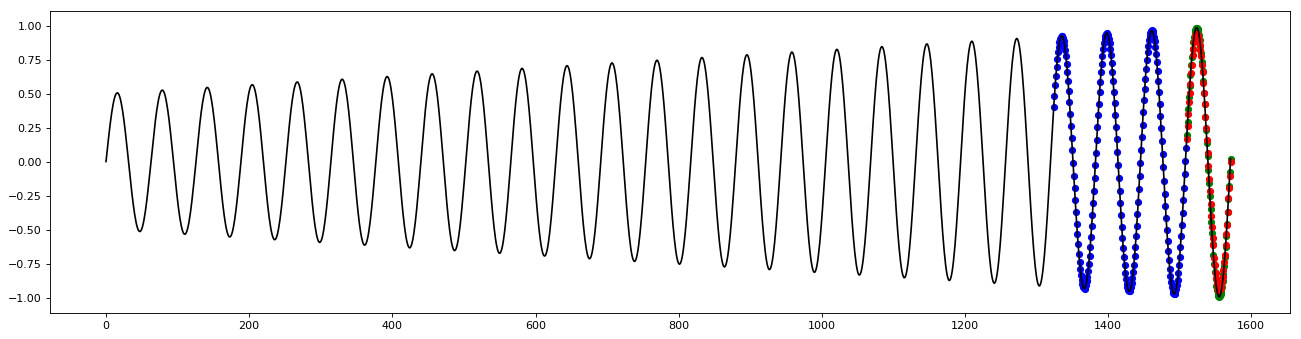

In [45]:
#Display forecasts

#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#data = data[:int(len(data)/2)]
plt.plot(data, color="black")



xs = [x for x in range(len(data))]
#plt.scatter(xs, data, color="blue", s = 15)






#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#print(len(test_y))
#print(len(y_hat))
#print(len(labels_x))
#mod_data = [y+ for y in data[-40:]]
#fake_y = [y for y in range()]



#Display true labels in green
#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

print("y size: " +str(len(y_hat)))
print("x size: " +str(len(labels_x)))


#Display the X of that this prediction was based on
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)
test_x_indices = [x for x in range(test_x_start, test_x_end)]

test_x_labels = [data[y] for y in test_x_indices]

print(len(test_x_indices))
print(len(test_x_labels))

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)

#Display forecasted labels in red
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]
plt.scatter(labels_x, y_hat, color="red", s=30)

print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))

In [51]:
from keras.models import Sequential
import numpy as np
from keras.layers import LSTM
from keras.layers import Dense
 
model = Sequential()
model.add(LSTM(2, input_shape=(2,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
 
x= np.array([[[1],[2]],[[3],[4]],[[5],[6]],[[7],[8]]])
y = np.array([1,2,3,4])
 
model.fit(x, y, nb_epoch=10, batch_size=2, verbose=1)


/Users/samcohen/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
4/4 [==============================] - 1s 287ms/step - loss: 8.9841
Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 8.9257
Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 8.8592
Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 8.7919
Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 8.7364
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 8.6759
Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 8.6077
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 8.5510
Epoch 9/10
4/4 [==============================] - 0s 2ms/step - loss: 8.4728
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 8.4180


In [52]:
print(model.predict([[[1],[3]], [[2],[4]], [[3],[5]]], batch_size=3))

AttributeError: 'list' object has no attribute 'ndim'

In [77]:
a = [1,2,3]
b = np.stack((a,a,a))
print(b.shape)

AttributeError: 'list' object has no attribute 'shape'